# Calculate NDWI for larger than memory images

This script calculates a version of Normalized Difference Water Index (NDWI) that uses the green band rather than the short-wave infrared (SWIR).  This version of the NDWI is more suited to monitoring water content in waterbodies.  The version that uses SWIR is more suited to monitoring changes in water content of leaves.

The formula is:

        ndwi = (green - nir) / (green + nir)

The imagery is read in and written out on a block by block basis.  This means that larger then memory imagery can be used.

In this example Sentinel 2 Level 2 imagery is used.

In [1]:
import rasterio
import os
import numpy as np
import matplotlib.pyplot as plt

This function is used to set up a generator for lazy loading of the image a block at time.

In [2]:
def imagegenerator(dataset):
    """
    set up generator for lazy loading of the image a block at a time
    """

    for window_index, window in dataset.block_windows(1):
        yield dataset.read(window=window)

This function calculates the ndwi and writes out the resulting image.

In [3]:
def calcndwi(bandfiles, outimg):
    """
    calculate ndwi on a block by block basis
    Parameters
    ----------
    bandfiles : list
        list of files for bands used
    outimg : string
        path to output image 
    """
    # get a list of open datasets
    datasets = list(map(rasterio.open, bandfiles))

    # build iterators of the images
    imgiterators = map(imagegenerator, datasets)

    # copy the profile and update
    profile =  datasets[0].profile.copy()
    profile.update(driver='GTiff',
                   dtype='float32')
    
    # create a new file
    with rasterio.open(outimg, 'w', **profile) as dst:

        # get a list of windows from dest dataset
        windows = [window for ij, window in dst.block_windows(1)]

        # loop through the images together
        for index, bands_windows in enumerate(zip(*imgiterators)):
            # note that the original images are in an unsigned integer 
            # format so the negative numbers that can result from the 
            # first part of the calculation are not handled properly
            # therefore convert to a more adept format
            green = bands_windows[0].astype(np.float32)
            nir = bands_windows[1].astype(np.float32)
            # calculate ndwi
            ndwi = (green - nir) / (green + nir)

            # get the output window
            window = windows[index]

            # write window of data
            dst.write(ndwi, window=window)

Carry out the calculation.

In [4]:
root = "data/sentinel"
band3 = "T30UXB_20180517T110621_B03_10m.jp2"
band8 = "T30UXB_20180517T110621_B08_10m.jp2"

bandfiles = [os.path.join(root, band3),
             os.path.join(root, band8)]

dstimage = "data/ndwi.tif"

calcndwi(bandfiles, dstimage)

C:\ProgramData\Anaconda3\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Display the resulting NDWI.

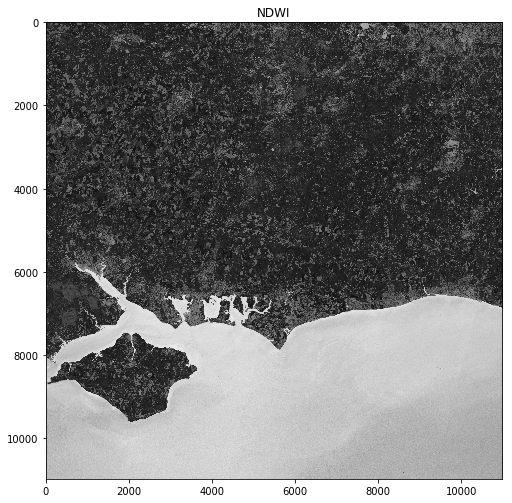

In [5]:
with rasterio.open(dstimage) as img:
    array = img.read(1)

plt.subplots(figsize=(18, 18))

plt.subplot(121)
plt.imshow(array, cmap=plt.cm.Greys_r)
plt.title('NDWI')

plt.show()